In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tslearn.metrics import dtw, dtw_path
import matplotlib.animation as animation
from IPython.display import HTML

/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


# Dynamic Time Wraping
> Images for explaning DTW in papers and thesis
> 
> Inspired on [An introduction to Dynamic Time Warping](https://rtavenar.github.io/blog/dtw.html#alignment-based-metrics)
>
> Interesting explanation: [Herman Kamper - Youtube](https://www.youtube.com/watch?v=ERKDHZyZDwA)
>
> Fundamentals of DTW joined [IEEE-2018](https://www.computer.org/csdl/journal/tp/2016/02/07062899/13rRUEgaru2)
> 

The goal in this notebook is to understand Alignment-based similarity meassures; and, more especifically, DTW.  This meassures rely on a temporal alignment of the series to asses their similarity. 

## Generate data

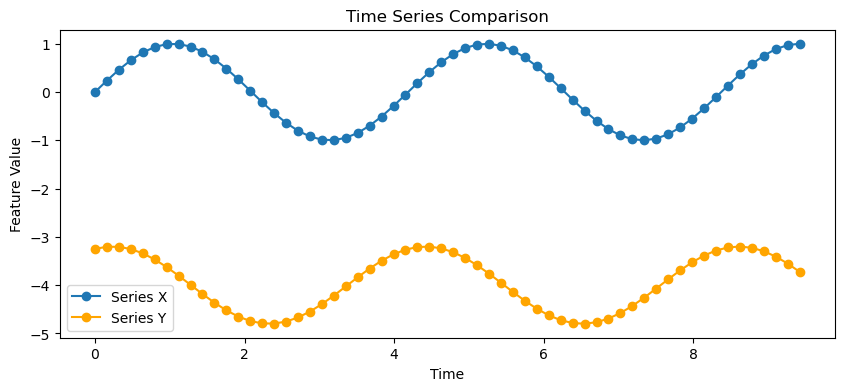

In [2]:
# Parameters
N = 60            # Number of points (using fewer points for clarity)
freq = 1.5        # Frequency of the sine wave (higher frequency -> narrower waves)
shift_t = 5.0     # Time shift for series Y
ampli_y = 0.8     # Amplitude factor for series Y
offset_y = -4.0   # Vertical offset for series Y

t = np.linspace(0, 3*np.pi, N)
series_x = np.sin(freq * t)
series_y = 0.8 * np.sin(2.0 * (t + 2.0)) - 1.0

# Series Y: same frequency, but time-shifted, with reduced amplitude and vertical offset
series_y = ampli_y * np.sin(freq * (t + shift_t)) + offset_y

plt.figure(figsize=(10, 4))
plt.plot(t, series_x, marker='o', linestyle='-', label='Series X')
plt.plot(t, series_y, marker='o', linestyle='-', color='orange', label='Series Y')
plt.title("Time Series Comparison")
plt.xlabel("Time")
plt.ylabel("Feature Value")
plt.legend()
plt.show()

## Euclidean distance

In [3]:
def plot_euclidean(t, series_x, series_y):
    plt.figure(figsize=(10, 4))
    plt.plot(t, series_x, marker='o', linestyle='-', label='Series X')
    plt.plot(t, series_y, marker='o', linestyle='-', color='orange', label='Series Y')

    # Draw vertical lines connecting each point at the same index
    for i in range(len(t)):
        plt.plot([t[i], t[i]], [series_x[i], series_y[i]], color='gray', alpha=0.5)

    plt.title("Euclidean Matching (Index-to-Index)")
    plt.xlabel("Time")
    plt.ylabel("Feature Value")
    plt.legend()
    plt.show()

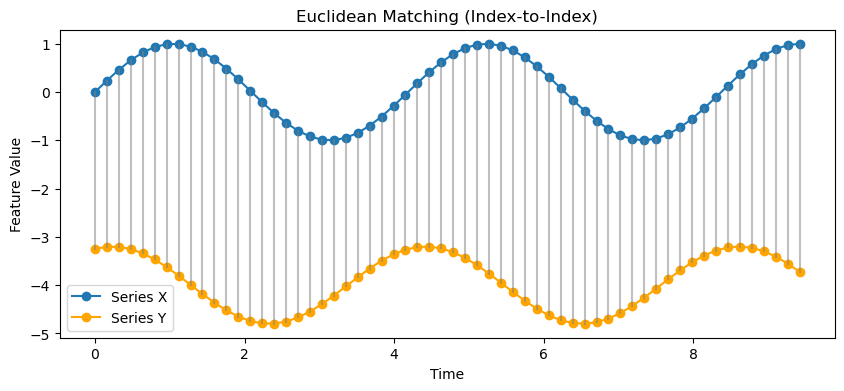

In [4]:
plot_euclidean(t, series_x, series_y)

## DTW

### Basic Alignment Matrix example

In [197]:
def save2svg_pdf(name):
    # Guardar en formato SVG y PDF
    svg_path = name+".svg"
    pdf_path = name+".pdf"
    plt.savefig(svg_path, format='svg', bbox_inches='tight')
    plt.savefig(pdf_path, format='pdf', bbox_inches='tight')
    # Mostrar enlaces de descarga en HTML
    download_links = f"""
    <a href="{svg_path}" download="{svg_path}">📥 Descargar SVG</a> |
    <a href="{pdf_path}" download="{pdf_path}">📥 Descargar PDF</a>
    """
    print("SVG path:", svg_path)
    print("PDF path:", pdf_path)
    display(HTML(download_links))

In [36]:
def path_cost(series_x, series_y, path):
    """
    Computes the sum of squared differences for a given path.
    Cost = sum( (series_x[i] - series_y[j])^2 for (i,j) in path ).
    """
    cost = 0.0
    for (i, j) in path:
        diff = series_x[i] - series_y[j]
        cost += diff**2
    return cost

In [157]:
def plot_path_time_and_matrix(
    t_x, series_x, t_y, series_y, path, dtw_cost=None, 
    title="DTW Example", file_name="dtw_example", 
    offset=4, connect_line_color='gray', connect_line_alpha=0.3,
    show_path_in_matrix=True, 
    legend_position="top"  # Posiciones: "top", "bottom", "left", "right"
):
    """
    Plots:
      1) The time series: series_x with time vector t_x and series_y with time vector t_y,
         with a vertical offset applied to series_y.
      2) A binary alignment matrix (0's and 1's) in a soft grey scale, with the alignment path overlaid.
      
    If dtw_cost is provided, it is displayed prominently on the first subplot.
    
    Parameters:
      t_x: time vector for series_x.
      series_x: first time series (1D).
      t_y: time vector for series_y.
      series_y: second time series (1D).
      path: list/array of (i, j) pairs representing the alignment path.
      dtw_cost: (optional) DTW cost to be displayed.
      title: title for the time series plot.
      file_name: filename for saving the image.
      offset: vertical offset added to series_y.
    """
    # Ensure the series are numpy arrays
    series_x = np.array(series_x)
    series_y = np.array(series_y)
    path = np.array(path)
    
    # Invert the path if it is returned in reverse order.
    path = path[::-1]
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: Time series with vertical offset for series_y
    ax[0].plot(t_x, series_x, 'o-', label="Series X")
    ax[0].plot(t_y, series_y + offset, 'o-', label="Series Y (offset)")
    
    if len(t_x) == len(t_y) and np.allclose(t_x, t_y):
        # Both time vectors are the same, so use t_x for both endpoints.
        for (i, j) in path:
            ax[0].plot([t_x[i], t_x[j]], [series_x[i], series_y[j] + offset],  color=connect_line_color, linestyle='--', alpha=connect_line_alpha)
    else:
        # Use the separate time vectors.
        for (i, j) in path:
            ax[0].plot([t_x[i], t_y[j]], [series_x[i], series_y[j] + offset],  color=connect_line_color, linestyle='--', alpha=connect_line_alpha)

    
    # Compute DTW cost if not provided (you need a path_cost function defined elsewhere)
    dtw_cost = dtw_cost if dtw_cost is not None else path_cost(series_x, series_y, path)
    
    # Display the DTW cost outside the plot area:
    # Position it slightly above the axis (in axes coordinates, y>1 means outside the top)
    ax[0].text(
        0,            # x-position in axis coordinates (0 = left, 1 = right)
        -0.5,          # y-position in axis coordinates (0 = bottom, 1 = top)
        f"DTW Cost: {dtw_cost:.2f}",
        transform=ax[0].transAxes,
        fontsize=16,    # same size as axis labels
        color='black',
        horizontalalignment='center',
        verticalalignment='center'
    )

    
    # Set title and axis labels with adjusted font sizes
    ax[0].set_title(title, fontsize=22, fontweight='bold', pad=20)
    ax[0].set_xlabel("Time", fontsize=16)
    ax[0].set_ylabel("Value", fontsize=16)
    ax[0].tick_params(axis='both', which='major', labelsize=12)
    legend_positions = {
        "top":    {"loc": "upper center", "bbox_to_anchor": (0.5, 1.15), "ncol": 3, "adjust": {"top": 0.85}},
        "bottom": {"loc": "upper center", "bbox_to_anchor": (0.5, -0.5), "ncol": 3, "adjust": {"bottom": 0.2}},
        "left":   {"loc": "center left", "bbox_to_anchor": (-0.5, 0.5), "ncol": 1, "adjust": {"left": 0.2}},
        "right":  {"loc": "center right", "bbox_to_anchor": (1.425, 0.5), "ncol": 1, "adjust": {"right": 0.8}}
    }

    if legend_position not in legend_positions:
        raise ValueError("legend_position debe ser 'top', 'bottom', 'left' o 'right'.")
    legend_config = legend_positions[legend_position]
    
    ax[0].legend(
        fontsize=14, 
        loc = legend_config['loc'], 
        bbox_to_anchor = 
        legend_config['bbox_to_anchor'], 
        ncol = legend_config['ncol']
    )
    
    # Plot 2: Binary Alignment Matrix using origin='upper'
    n = len(series_x)
    m = len(series_y)
    binary_matrix = np.zeros((n, m))
    for (i, j) in path:
        binary_matrix[i, j] = 1
    im = ax[1].imshow(binary_matrix, origin='upper', cmap='Greys',
                        interpolation='nearest', aspect='auto', vmin=0, vmax=1)
    # Overlay the alignment path
    if show_path_in_matrix:
        ax[1].plot(path[:, 1], path[:, 0], 'r-', linewidth=2)
    ax[1].set_title("Binary Alignment Matrix", fontsize=22, fontweight='bold', pad=20)
    ax[1].set_xlabel("Index Y", fontsize=16)
    ax[1].set_ylabel("Index X", fontsize=16)
    ax[1].tick_params(axis='both', which='major', labelsize=12)
    # Optionally, remove the colorbar if it causes confusion
    # plt.colorbar(im, ax=ax[1])
    
    plt.tight_layout()
    save2svg_pdf(file_name)
    plt.show()
    return path, binary_matrix


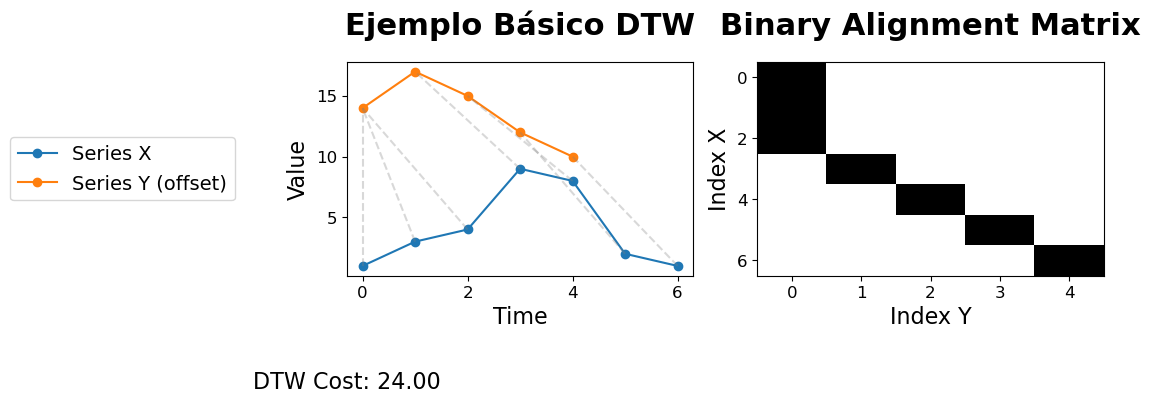

(array([[6, 4],
        [5, 3],
        [4, 2],
        [3, 1],
        [2, 0],
        [1, 0],
        [0, 0]]),
 array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]]))

In [140]:
basic_x = np.array([1, 3, 4, 9, 8, 2, 1])
basic_y = np.array([4, 7, 5, 2, 0])

# dtw_path con tslearn requiere forma 2D: (n, 1)
X = basic_x.reshape(-1, 1)
Y = basic_y.reshape(-1, 1)
path, dist = dtw_path(X, Y)

# Vector de índices para el eje X de la gráfica
basic_t = np.arange(len(basic_x))
basic_t2 = np.arange(len(basic_y))
plot_path_time_and_matrix(
    t_x = basic_t, t_y = basic_t2, series_x = basic_x, series_y = basic_y, path = path, 
    title="Ejemplo Básico DTW",file_name="ejemplo_basico_dtw", 
    offset = 10, show_path_in_matrix = False,
    legend_position = "left"
)

In [209]:
def path_matrix(series_x, series_y, path):
    """
    Computes the sum of squared differences for a given path.
    Cost = sum( (series_x[i] - series_y[j])^2 for (i,j) in path ).
    """
    cost = np.zeros((len(series_x), len(series_y)))
    for (i, j) in path:
        diff = series_x[i] - series_y[j]
        cost[i,j] = diff**2 # euclidean distance
    return cost_matrix

def cost_matrix(series_x, series_y):
    """
    Computes the sum of squared differences for a given path.
    Cost = sum( (series_x[i] - series_y[j])^2 for (i,j) in path ).
    """
    cost = np.zeros((len(series_x), len(series_y)))
    for i in range(len(series_x)):
        for j in range(len(series_y)):
            diff = series_x[i] - series_y[j]
            cost[i,j] = diff**2 # euclidean distance
    return cost

[[ 1.  1.  9. 36. 16.  1.  1.]
 [ 1.  1.  1. 16.  4.  1.  9.]
 [ 4.  4.  0.  9.  1.  4. 16.]
 [49. 49. 25.  4. 16. 49. 81.]
 [36. 36. 16.  1.  9. 36. 64.]
 [ 0.  0.  4. 25.  9.  0.  4.]
 [ 1.  1.  9. 36. 16.  1.  1.]]
SVG path: ejemplo_basico_valid_path_1.svg
PDF path: ejemplo_basico_valid_path_1.pdf


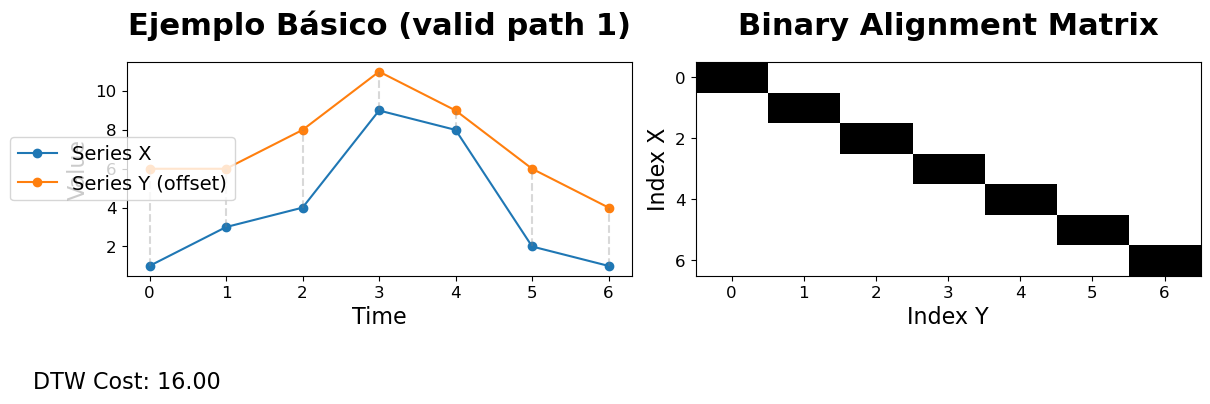

SVG path: ejemplo_basico_valid_path_2.svg
PDF path: ejemplo_basico_valid_path_2.pdf


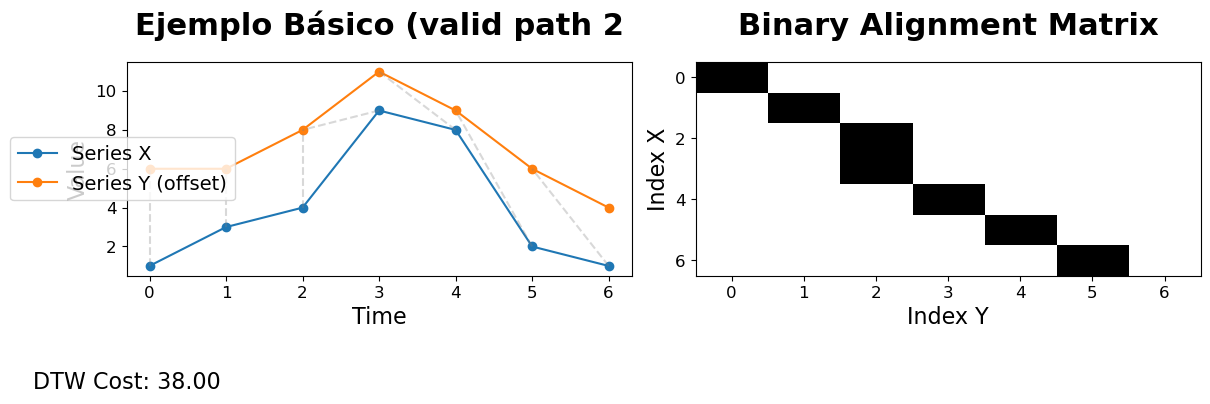

SVG path: ejemplo_basico_valid_path_3.svg
PDF path: ejemplo_basico_valid_path_3.pdf


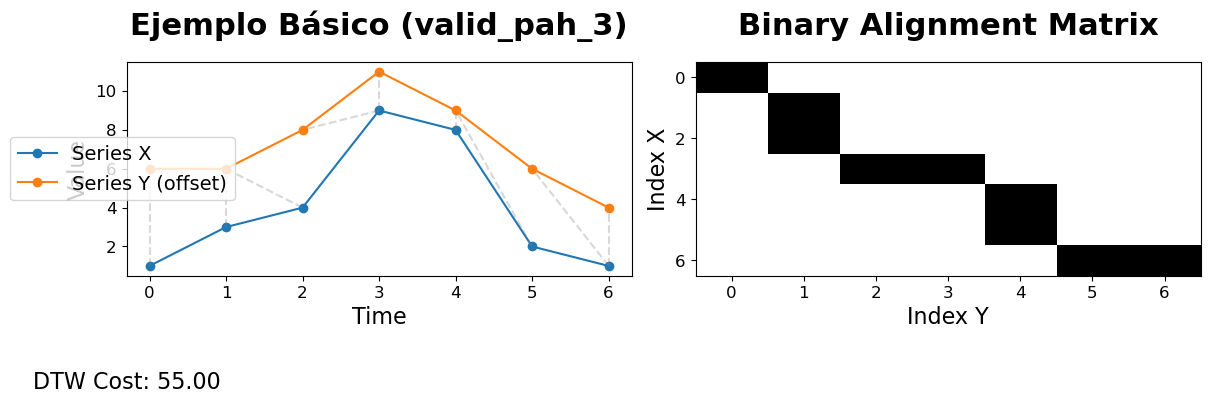

SVG path: ejemplo_basico_path_dtw.svg
PDF path: ejemplo_basico_path_dtw.pdf


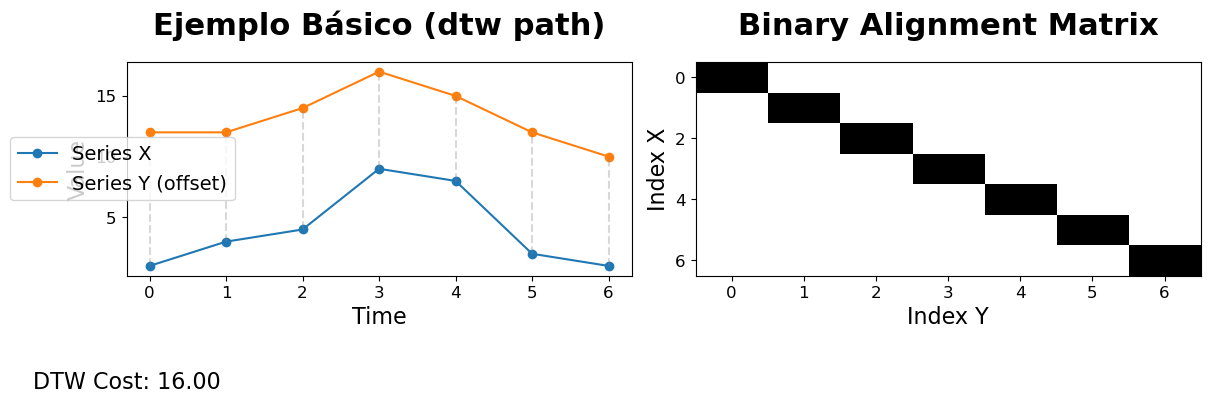

[[1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]
[[1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]]
[[1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1.]]


In [210]:
import numpy as np

basic_x = np.array([1, 3, 4, 9, 8, 2, 1])
basic_y = np.array([2, 2, 4, 7, 5, 2, 0])
toy_path_1 = [(i, i) for i in range(len(basic_x))]
toy_path_2 = [(0,0), (1,1), (2,2), (3,2), (4,3), (5,4), (6,5)]
toy_path_3 = [(0,0), (1,1), (2,1), (3,2), (3,3), (4,4), (5,4), (6,5), (6,6)]
# Create time vectors for each series:
basic_t = np.arange(len(basic_x))
basic_t2 = np.arange(len(basic_y))

X = basic_x.reshape(-1, 1)
Y = basic_y.reshape(-1, 1)
path, dist = dtw_path(X, Y)
cm = cost_matrix(basic_x, basic_y)
print(cm)

path1, matrix1 = plot_path_time_and_matrix(basic_t, basic_x, basic_t2, basic_y, toy_path_1,
                            title="Ejemplo Básico (valid path 1)",
                            file_name="ejemplo_basico_valid_path_1", offset=4,
                            show_path_in_matrix=False, legend_position = "left")

path2, matrix2 = plot_path_time_and_matrix(basic_t, basic_x, basic_t2, basic_y, toy_path_2,
                            title="Ejemplo Básico (valid path 2",
                            file_name="ejemplo_basico_valid_path_2", offset=4,
                            show_path_in_matrix=False, legend_position = "left")
path3, matrix3 = plot_path_time_and_matrix(basic_t, basic_x, basic_t2, basic_y, toy_path_3,
                            title="Ejemplo Básico (valid_pah_3)",
                            file_name="ejemplo_basico_valid_path_3", offset=4,
                            show_path_in_matrix=False, legend_position = "left")
plot_path_time_and_matrix(t_x = basic_t, t_y = basic_t2, series_x = basic_x, series_y = basic_y, 
                          path = path, title="Ejemplo Básico (dtw path)",
                          file_name="ejemplo_basico_path_dtw", 
                          offset = 10, show_path_in_matrix = False,  legend_position = "left")

cost_matrix1 = path_matrix(basic_x, basic_y, path1)
cost_matrix1 = path_matrix(basic_x, basic_y, path2)
cost_matrix1 = path_matrix(basic_x, basic_y, path3)

print(matrix1)
print(matrix2)
print(matrix3)

In [195]:
#TODO: Hacer que la caja aparezca bien independientemente del índice
import matplotlib.patches as patches

def plot_paths_time_and_matrixes(
    t_x, 
    series_x, 
    t_y, 
    series_y, 
    list_of_paths,
    costs=None,  # List of DTW costs for each path; if None, they are computed.
    offset=4, 
    connect_line_color='gray', 
    connect_line_alpha=0.3,
    show_path_in_matrix=False, 
    best_path_index=None,  # Index of the best (lowest cost) path to highlight.
    fig_title="Multiple Paths", 
    file_name="multiple_paths",
    legend_position="top"  # Options: "top", "bottom", "left", "right"
):
    """
    Plots multiple alignment paths in a single figure.
    Each row contains two subplots:
      - Left subplot: time series plot with alignment lines.
      - Right subplot: binary alignment matrix with path overlay.
    If best_path_index is provided, a red rectangle is drawn around that row.
    """
    
    # Helper function to compute the cost of a given path.
    def path_cost(x, y, path):
        return sum((x[i] - y[j])**2 for (i, j) in path)
    
    # Compute costs if not provided.
    if costs is None:
        costs = [path_cost(series_x, series_y, p) for p in list_of_paths]
        
    n_paths = len(list_of_paths)
    fig, axes = plt.subplots(n_paths, 2, figsize=(10, 4 * n_paths))
    if n_paths == 1:
        axes = np.array([axes])
        
    legend_positions = {
        "top": {"loc": "upper center", "bbox_to_anchor": (0.5, 1.15), "ncol": 3},
        "bottom": {"loc": "upper center", "bbox_to_anchor": (0.5, -0.5), "ncol": 3},
        "left": {"loc": "center left", "bbox_to_anchor": (-0.5, 0.5), "ncol": 1},
        "right": {"loc": "center right", "bbox_to_anchor": (1.425, 0.5), "ncol": 1}
    }
    if legend_position not in legend_positions:
        raise ValueError("Invalid legend position. Choose from 'top', 'bottom', 'left', or 'right'.")
    
    for i, (path, cost) in enumerate(zip(list_of_paths, costs)):
        ax_time = axes[i, 0]
        ax_matrix = axes[i, 1]
        
        # Ensure the path is a numpy array; reverse if necessary.
        path = np.array(path)
        if len(path) > 1 and (path[0][0] > path[-1][0] or path[0][1] > path[-1][1]):
            path = path[::-1]
        
        # Plot time series on the left subplot.
        ax_time.plot(t_x, series_x, 'o-', label="Series X")
        ax_time.plot(t_y, series_y + offset, 'o-', label="Series Y (offset)")
        if len(t_x) == len(t_y) and np.allclose(t_x, t_y):
            for (ii, jj) in path:
                ax_time.plot([t_x[ii], t_x[jj]],
                             [series_x[ii], series_y[jj] + offset],
                             color=connect_line_color, linestyle='--',
                             alpha=connect_line_alpha)
        else:
            for (ii, jj) in path:
                ax_time.plot([t_x[ii], t_y[jj]],
                             [series_x[ii], series_y[jj] + offset],
                             color=connect_line_color, linestyle='--',
                             alpha=connect_line_alpha)
        # Display the DTW cost.
        ax_time.text(0.0, 1.02, f"DTW Cost: {cost:.2f}",
                     transform=ax_time.transAxes,
                     fontsize=12, color='black',
                     horizontalalignment='left', verticalalignment='bottom')
        ax_time.set_xlabel("Time", fontsize=12)
        ax_time.set_ylabel("Value", fontsize=12)
        ax_time.tick_params(axis='both', labelsize=10)
        #ax_time.legend(fontsize=10,
        #               loc=legend_positions[legend_position]["loc"],
        #               bbox_to_anchor=legend_positions[legend_position]["bbox_to_anchor"],
        #               ncol=legend_positions[legend_position]["ncol"])
        
        # Plot binary alignment matrix on the right subplot.
        n = len(series_x)
        m = len(series_y)
        binary_matrix = np.zeros((n, m))
        for (ii, jj) in path:
            binary_matrix[ii, jj] = 1
        ax_matrix.imshow(binary_matrix, origin='upper', cmap='Greys',
                         interpolation='nearest', aspect='auto', vmin=0, vmax=1)
        if show_path_in_matrix:
            ax_matrix.plot(path[:, 1], path[:, 0], 'r-', linewidth=2)
        ax_matrix.set_xlabel("Index Y", fontsize=12)
        ax_matrix.set_ylabel("Index X", fontsize=12)
        ax_matrix.set_title(f"Path {i+1}", fontsize=14)
        
        # If this is the best path, highlight the entire row with a rectangle.
        if best_path_index is not None and i == best_path_index:
            # Get bounding boxes of both subplots in figure coordinates.
            bbox_time = ax_time.get_position()
            bbox_matrix = ax_matrix.get_position()
            # Compute the combined bounding box for the entire row.
            left = bbox_time.x0 - 0.15
            bottom = min(bbox_time.y0, bbox_matrix.y0) - 0.04
            right = bbox_matrix.x1 + 0.125
            top = max(bbox_time.y1, bbox_matrix.y1) + 0.05
            width = right - left
            height = top - bottom
            # Draw a red rectangle around the row.
            rect = patches.Rectangle((left, bottom), width, height,
                                     fill=False, edgecolor='red', linewidth=2,
                                     transform=fig.transFigure, zorder=10)
            fig.add_artist(rect)
    
    fig.suptitle(fig_title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    # Get handles and labels from the first axis (they are common to all)
    handles, labels = axes[0, 0].get_legend_handles_labels()
    # Add a common legend at the bottom of the entire figure
    fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))
    save2svg_pdf(file_name)
    plt.show()

SVG path: multiple_paths_example.svg
PDF path: multiple_paths_example.pdf


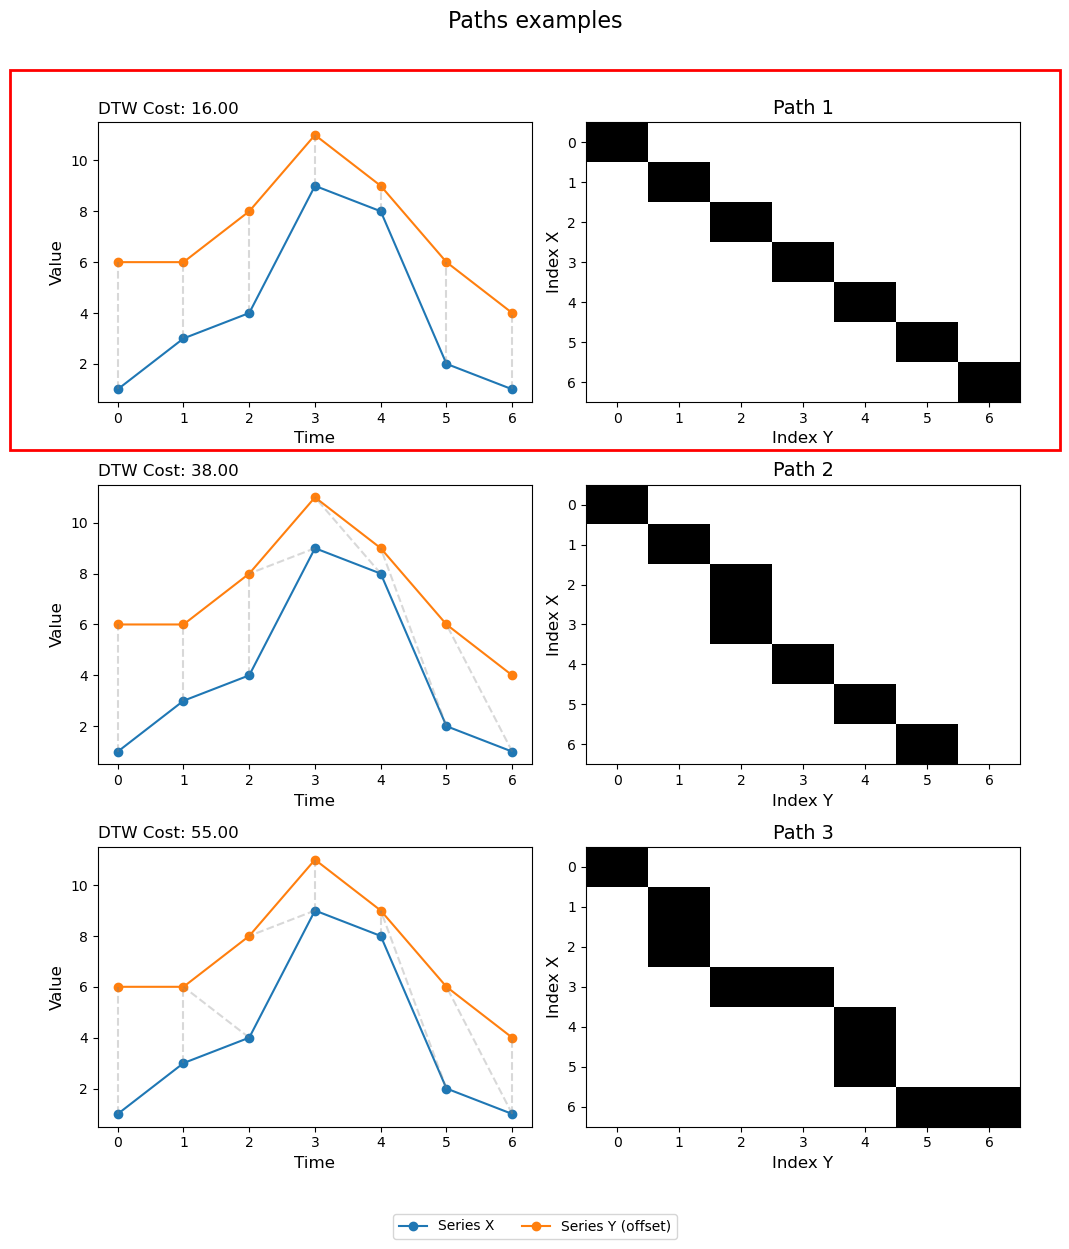

In [198]:
all_paths = [toy_path_1, toy_path_2, toy_path_3]
best_index = 0

plot_paths_time_and_matrixes(
    t_x=range(len(basic_x)), series_x=basic_x,
    t_y=range(len(basic_y)), series_y=basic_y,
    list_of_paths=all_paths,
    best_path_index=best_index,
    fig_title="Paths examples",
    file_name="multiple_paths_example",
    offset=4,
    show_path_in_matrix=False,
    legend_position="left"
)

Length of x2: 90
Length of y2: 100
[(0, 0), (1, 1), (2, 2), (3, 2), (4, 3), (5, 3), (6, 4), (7, 4), (8, 4), (9, 4), (10, 5), (10, 6), (11, 7), (12, 7), (13, 8), (14, 9), (15, 10), (16, 10), (17, 11), (18, 12), (19, 13), (20, 13), (21, 13), (22, 14), (23, 15), (24, 16), (25, 17), (26, 17), (27, 18), (28, 18), (29, 19), (30, 20), (31, 21), (32, 21), (33, 22), (34, 23), (35, 24), (36, 25), (37, 25), (38, 26), (39, 26), (40, 27), (41, 27), (42, 27), (43, 28), (43, 29), (44, 30), (45, 30), (46, 31), (47, 31), (48, 32), (49, 32), (50, 33), (51, 34), (52, 35), (53, 35), (54, 36), (55, 36), (56, 37), (57, 38), (58, 39), (59, 40), (59, 41), (59, 42), (59, 43), (59, 44), (59, 45), (59, 46), (59, 47), (59, 48), (59, 49), (60, 50), (60, 51), (60, 52), (60, 53), (60, 54), (60, 55), (60, 56), (60, 57), (60, 58), (60, 59), (61, 60), (62, 61), (63, 62), (64, 63), (65, 63), (66, 64), (67, 65), (68, 65), (69, 66), (70, 67), (71, 67), (72, 68), (73, 68), (74, 69), (75, 70), (76, 71), (77, 71), (78, 72), 

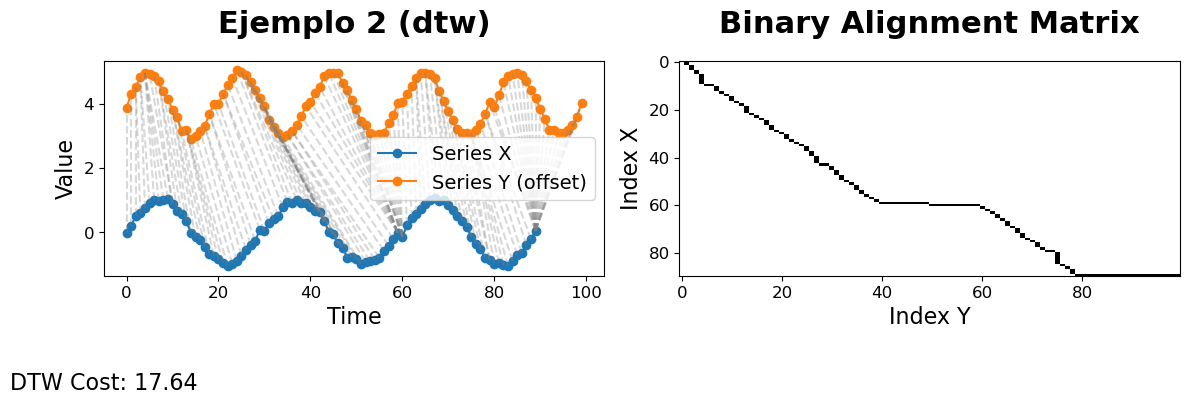

In [101]:
# Generate series_x: 3 repeated sine cycles, each cycle has 30 points
# This creates 90 points total. We add minimal noise for variety.
base_cycle_x = np.sin(np.linspace(0, 2*np.pi, 30))
x2 = np.tile(base_cycle_x, 3) + 0.05 * np.random.randn(90)

# Generate series_y: 5 repeated sine cycles, each cycle has 20 points
# This creates 100 points total. Also add minimal noise.
base_cycle_y = np.sin(np.linspace(0, 2*np.pi, 20))
y2 = np.tile(base_cycle_y, 5) + 0.05 * np.random.randn(100)

# The time vectors
tx = np.arange(len(x2))
ty = np.arange(len(y2))

print("Length of x2:", len(x2))
print("Length of y2:", len(y2))

# Compute DTW path and cost using tslearn.dtw_path. 
# Note: tslearn requires 2D arrays, so we reshape the series.
X = x2.reshape(-1, 1)
Y = y2.reshape(-1, 1)
path, cost = dtw_path(X, Y)
print(path)

# Call the plotting function (assumes plot_path_time_and_matrix is defined)
plot_path_time_and_matrix(tx, x2, ty, y2, path,
                          title="Ejemplo 2 (dtw)",
                          file_name="ejemplo_2_dtw",
                          offset=4, show_path_in_matrix = False)

### Back to the original series

60
60
60
Distance 31.251691329314948
Path [(0, 0), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 3), (8, 4), (9, 5), (10, 6), (11, 7), (12, 8), (13, 9), (14, 10), (15, 11), (16, 12), (17, 13), (18, 14), (19, 15), (20, 16), (21, 17), (22, 18), (23, 19), (24, 20), (25, 21), (26, 22), (27, 23), (28, 24), (29, 25), (30, 26), (31, 27), (32, 28), (33, 29), (34, 30), (35, 31), (36, 32), (37, 33), (38, 34), (39, 35), (40, 36), (41, 37), (42, 38), (43, 39), (44, 40), (45, 41), (46, 42), (46, 43), (46, 44), (46, 45), (46, 46), (47, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59)]


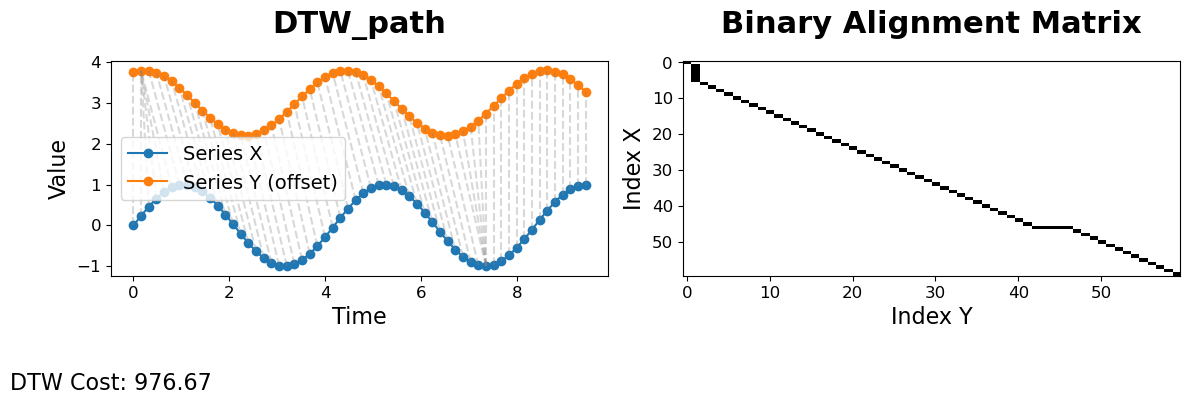

In [112]:
N = 60            # Number of points (using fewer points for clarity)
freq = 1.5        # Frequency of the sine wave (higher frequency -> narrower waves)
shift_t = 5.0     # Time shift for series Y
ampli_y = 0.8     # Amplitude factor for series Y
offset_y = -4.0   # Vertical offset for series Y

t = np.linspace(0, 3*np.pi, N)
series_x = np.sin(freq * t)
series_y = 0.8 * np.sin(2.0 * (t + 2.0)) - 1.0

# Series Y: same frequency, but time-shifted, with reduced amplitude and vertical offset
series_y = ampli_y * np.sin(freq * (t + shift_t)) + offset_y
X = series_x.reshape(-1, 1)
Y = series_y.reshape(-1, 1)
print(len(X))
print(len(Y))
print(len(t))
path, dtw_distance = dtw_path(X, Y)
print("Distance", dtw_distance)
print("Path", path)
plot_path_time_and_matrix(t_x = t[:60], t_y = t[:60], series_x = series_x, series_y = series_y, path = path, title="DTW_path", file_name="DTW_path", offset = 7, show_path_in_matrix = False)

### Otros intentos

In [ ]:
def plot_dtw(t, series_x, series_y):
    # Reshape series to 2D arrays as required by tslearn (shape: [n_samples, n_features])
    X = series_x.reshape(-1, 1)
    Y = series_y.reshape(-1, 1)

    # Compute the DTW path and distance using tslearn's dtw_path function
    path, dtw_distance = dtw_path(X, Y)

    plt.figure(figsize=(10, 4))
    # For DTW, we use indices since the two series share the same time vector 't'
    plt.plot(np.arange(len(series_x)), series_x, marker='o', linestyle='-', label='Series X')
    plt.plot(np.arange(len(series_y)), series_y, marker='o', linestyle='-', color='orange', label='Series Y')

    # Draw lines according to the DTW alignment path
    for (i, j) in path:
        plt.plot([i, j], [series_x[i], series_y[j]], color='gray', alpha=0.5)

    plt.title(f"DTW Alignment (Distance = {dtw_distance:.4f})")
    plt.xlabel("Index")
    plt.ylabel("Feature Value")
    plt.legend()
    plt.show()

In [ ]:
plot_dtw(t, series_x, series_y)

In [ ]:
def animate_dtw_alignment(t, series_x, series_y, interval=50):
    """
    Creates an animation of the DTW alignment between series_x and series_y.
    
    Parameters:
        t : array-like
            Common time vector for the series.
        series_x : array-like
            First time series.
        series_y : array-like
            Second time series.
        interval : int, optional
            Delay between frames in milliseconds (default is 50).
    
    Returns:
        ani : matplotlib.animation.FuncAnimation
            The animation object.
    """
    # Compute the DTW path using tslearn.metrics.dtw_path
    # Reshape series for dtw_path (expects 2D arrays)
    X = series_x.reshape(-1, 1)
    Y = series_y.reshape(-1, 1)
    path, dtw_distance = dtw_path(X, Y)
    
    # Create the figure and plot the two series
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(t, series_x, marker='o', linestyle='-', label='Series X')
    ax.plot(t, series_y, marker='o', linestyle='-', color='orange', label='Series Y')
    ax.set_title("DTW Alignment Animation")
    ax.set_xlabel("Time")
    ax.set_ylabel("Feature Value")
    ax.legend()
    
    # List to store DTW matching line objects
    dtw_lines = []
    
    def init():
        # Initialization function for the animation: no lines drawn at first.
        return dtw_lines
    
    def update(frame):
        nonlocal dtw_lines
        # Remove previously drawn DTW lines
        for line in dtw_lines:
            line.remove()
        dtw_lines = []
        # Draw DTW matching lines up to the current frame index
        for k in range(frame + 1):
            i, j = path[k]
            line, = ax.plot([t[i], t[j]], [series_x[i], series_y[j]], color='gray', alpha=0.5)
            dtw_lines.append(line)
        return dtw_lines
    
    ani = animation.FuncAnimation(fig, update, frames=len(path), init_func=init, blit=True, interval=interval)
    return ani

In [ ]:
%matplotlib widget

In [ ]:
ani = animate_dtw_alignment(t, series_x, series_y, interval=50)
plt.show()

In [ ]:
def animate_time_warp(t, series_x, series_y, interval=100):
    """
    1) Create an animation (GIF) showing how the top series (X) is progressively
       warped to align with the bottom series (Y).
       
       We compute the DTW path, and at each frame we reconstruct a "warped" version
       of X up to that partial alignment, so it visually appears that X is 'moving'
       or 'stretching' to match Y.
       
    Parameters
    ----------
    t : array-like
        Time vector for both series (same length for X).
    series_x : array-like
        First time series, length N.
    series_y : array-like
        Second time series, length N (for simplicity here).
    interval : int
        Delay between frames in ms.
        
    Returns
    -------
    ani : FuncAnimation
        The animation object.
    """
    # Convert to 2D for tslearn
    X_2d = series_x.reshape(-1, 1)
    Y_2d = series_y.reshape(-1, 1)
    path, dist = dtw_path(X_2d, Y_2d)
    # path is a list of (i, j) pairs with i in [0..N-1], j in [0..N-1], if X and Y have same length.

    N = len(series_x)
    fig, ax = plt.subplots(figsize=(10, 4))

    # We'll keep a "warped_X" array that re-samples X to match Y's time index
    # For convenience, we assume both X and Y have same length N. We'll fill "warped_X" with NaN initially.
    warped_X = np.full(N, np.nan)

    # Plot Y as reference
    ax.plot(t, series_y, 'o-', color='orange', label='Series Y (target)')
    # We'll plot the evolving warped_X in blue
    line_warped, = ax.plot(t, warped_X, 'o-', color='blue', label='Warped X (partial)')
    ax.set_title("Animation: Warping X to match Y")
    ax.set_xlabel("Time")
    ax.set_ylabel("Feature Value")
    ax.legend(loc='best')

    def init():
        # No partial alignment yet
        line_warped.set_ydata(np.full(N, np.nan))
        return [line_warped]

    def update(frame):
        # We consider path up to 'frame'
        partial_path = path[:frame+1]
        # partial_path is a list of (i, j). For each pair, we say that X[i] is mapped to Y[j].
        # We'll place X[i] at the time t[j].
        # So for that j, warped_X[j] = series_x[i].
        # Because some j might appear multiple times, we'll just set the last match we find.

        # Reset warped_X each frame
        new_warp = np.full(N, np.nan)
        for (i, j) in partial_path:
            new_warp[j] = series_x[i]

        line_warped.set_ydata(new_warp)
        return [line_warped]

    ani = animation.FuncAnimation(fig, update, frames=len(path), init_func=init,
                                  blit=False, interval=interval)
    return ani

In [ ]:
ani = animate_time_warp(t, series_x, series_y, interval=200)
plt.show()
# Or save as GIF (requires imagemagick):
# ani.save("dtw_matrix_and_path.gif", writer="imagemagick")

In [ ]:
def plot_dtw_path_matrix(series_x, series_y, path):
    """
    2) Plot a static figure showing the DTW path as dots on a matrix representation.
       Each axis corresponds to an index of X or Y.
       We'll create a NxM matrix with 1's on the path positions, 0's elsewhere.
    """
    Nx = len(series_x)
    Ny = len(series_y)
    
    # Build a binary matrix for the path
    mat_bin = np.zeros((Nx, Ny))
    for (i, j) in path:
        mat_bin[i, j] = 1

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(mat_bin, cmap='Greys', origin='lower', aspect='auto')
    ax.set_title("DTW Path in Matrix (Dots = path cells)")
    ax.set_xlabel("Index j (Series Y)")
    ax.set_ylabel("Index i (Series X)")
    plt.show()

In [ ]:
def plot_dtw_path_static(t, series_x, series_y, path, title="DTW Alignment (Static)"):
    """
    Plot two time series along with alignment lines defined by a DTW path.
    
    Parameters
    ----------
    t : array-like
        The common time vector (or index array) for the series.
    series_x : array-like
        First time series.
    series_y : array-like
        Second time series.
    path : list of tuples
        A list of (i, j) pairs defining the alignment between series_x and series_y.
    title : str, optional
        The title of the plot.
        
    This function plots series_x and series_y (using t for both),
    and then draws gray lines connecting points at indices i and j as defined in the path.
    This visualizes what it means to "follow" a DTW path to align the series.
    """
    plt.figure(figsize=(10, 4))
    
    # Plot the two series using markers and lines
    plt.plot(t, series_x, 'o-', label='Series X')
    plt.plot(t, series_y, 'o-', color='orange', label='Series Y')
    
    # Draw alignment lines based on the DTW path
    for (i, j) in path:
        plt.plot([t[i], t[j]], [series_x[i], series_y[j]], color='gray', alpha=0.5)
    
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Feature Value")
    plt.legend()
    plt.show()

In [ ]:
X_2d = series_x.reshape(-1, 1)
Y_2d = series_y.reshape(-1, 1)
path, dist = dtw_path(X_2d, Y_2d)

In [ ]:
plot_dtw_path_matrix(series_x, series_y, path)

In [ ]:
plot_dtw_path_static(t, series_x, series_y, path)

In [ ]:
def generate_toy_paths(Nx, Ny, num_paths=3, seed=42):
    """
    Generate 'num_paths' random monotonic paths from (0,0) to (Nx-1, Ny-1).
    Each path is a list of (i,j) pairs, only moving right (0,1), down (1,0), or diagonal (1,1).
    """
    np.random.seed(seed)
    paths = []
    for _ in range(num_paths):
        path = [(0,0)]
        i, j = 0, 0
        while (i < Nx-1) or (j < Ny-1):
            # possible moves
            moves = []
            if i < Nx-1:
                moves.append((1,0))   # down
            if j < Ny-1:
                moves.append((0,1))   # right
            if i < Nx-1 and j < Ny-1:
                moves.append((1,1))   # diagonal
            step = moves[np.random.randint(len(moves))]
            i, j = i + step[0], j + step[1]
            path.append((i,j))
        paths.append(path)
    return paths

In [ ]:
def plot_multiple_paths_matrix(paths, Nx, Ny):
    """
    Create a static plot that shows multiple paths in a Nx x Ny matrix.
    Each path is drawn with dots or a line of some color.
    """
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_title("Multiple Paths in an Nx x Ny Matrix")
    ax.set_xlabel("j index")
    ax.set_ylabel("i index")
    ax.set_xlim(-0.5, Ny-0.5)
    ax.set_ylim(-0.5, Nx-0.5)
    ax.invert_yaxis()  # so (0,0) is top-left, if you want that style
    # you could also do origin='lower' if you prefer imshow style

    # draw grid lines
    for i in range(Nx):
        ax.axhline(i-0.5, color='gray', linewidth=0.5)
    for j in range(Ny):
        ax.axvline(j-0.5, color='gray', linewidth=0.5)

    # plot each path
    for idx, path in enumerate(paths):
        path_i = [p[0] for p in path]
        path_j = [p[1] for p in path]
        ax.plot(path_j, path_i, marker='o', linestyle='-', label=f'Path {idx+1}')
    ax.legend()
    plt.show()

In [ ]:
def animate_paths_in_matrix(paths, Nx, Ny, interval=300):
    """
    Animate multiple paths, one by one, in a Nx x Ny matrix.
    In each frame, we draw the partial path for each route.
    """
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_title("Animation of Multiple Paths")
    ax.set_xlabel("j index")
    ax.set_ylabel("i index")
    ax.set_xlim(-0.5, Ny-0.5)
    ax.set_ylim(-0.5, Nx-0.5)
    ax.invert_yaxis()

    # draw grid lines
    for i in range(Nx):
        ax.axhline(i-0.5, color='gray', linewidth=0.5)
    for j in range(Ny):
        ax.axvline(j-0.5, color='gray', linewidth=0.5)

    # We'll keep line objects for each path
    lines = []
    for idx in range(len(paths)):
        line_obj, = ax.plot([], [], marker='o', linestyle='-', label=f'Path {idx+1}')
        lines.append(line_obj)
    ax.legend()

    # figure out the max length among all paths
    max_len = max(len(p) for p in paths)

    def init():
        for ln in lines:
            ln.set_data([], [])
        return lines

    def update(frame):
        # For each path, show partial path up to 'frame'
        for idx, path in enumerate(paths):
            sub_path = path[:frame+1]
            i_coords = [pt[0] for pt in sub_path]
            j_coords = [pt[1] for pt in sub_path]
            lines[idx].set_data(j_coords, i_coords)
        return lines

    ani = animation.FuncAnimation(
        fig, update,
        frames=max_len,
        init_func=init,
        interval=interval,
        blit=False
    )
    return ani

In [ ]:
Nx, Ny = 10, 12  # matrix size
toy_paths = generate_toy_paths(Nx, Ny, num_paths=3, seed=1)

In [ ]:
plot_multiple_paths_matrix(toy_paths, Nx, Ny)

In [ ]:
ani = animate_paths_in_matrix(toy_paths, Nx, Ny, interval=500)

In [ ]:
def path_cost(series_x, series_y, path):
    """
    Computes the sum of squared differences for a given path.
    Cost = sum( (series_x[i] - series_y[j])^2 for (i,j) in path ).
    """
    cost = 0.0
    for (i, j) in path:
        diff = series_x[i] - series_y[j]
        cost += diff**2
    return cost

In [40]:
def plot_path_time_and_matrix(t, series_x, series_y, path, title="Custom Path", file_name="path_time_and_matrix", offset = 4):
    """
    Plot two subplots side by side:
      - Left: time-domain view of the two series with lines for the given path.
      - Right: Nx x Ny binary matrix with 1's on the path positions.
    The figure's suptitle shows the total path cost.
    
    Additionally, the plot is saved as a PDF and the binary matrix as a CSV,
    using the file_name parameter (default: "path_time_and_matrix") in the current directory.
    Download links for both files are then displayed.
    
    Parameters
    ----------
    t : array-like
        Time or index array for the series (if same length).
    series_x : array-like
        First series, length Nx.
    series_y : array-like
        Second series, length Ny.
    path : list of (i, j)
        The alignment path.
    title : str, optional
        Title prefix for the figure.
    file_name : str, optional
        Base name for the saved files (PDF and CSV). Default is "path_time_and_matrix".
    """
    Nx = len(series_x)
    Ny = len(series_y)

    # Compute the path cost
    c = path_cost(series_x, series_y, path)

    # Build a binary matrix for the path
    mat_bin = np.zeros((Nx, Ny))
    for (i, j) in path:
        mat_bin[i, j] = 1

    fig, (ax_left, ax_right) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    fig.suptitle(f"{title} | Path cost = {c:.4f}", fontsize=14)

    # --- Left Subplot: Time-Domain View ---
    ax_left.plot(t, series_x, 'o-', label='Series X')
    if Nx != Ny:
        # Create a separate time vector for series_y if lengths differ
        t2 = np.linspace(t[0], t[-1], Ny)
        ax_left.plot(t2, series_y, 'o-', color='orange', label='Series Y')
        for (i, j) in path:
            x_t = t[i]
            y_t = t2[j]
            ax_left.plot([x_t, y_t], [series_x[i], series_y[j]], color='gray', alpha=0.5)
    else:
        ax_left.plot(t, series_y, 'o-', color='orange', label='Series Y')
        for (i, j) in path:
            ax_left.plot([t[i], t[j]], [series_x[i], series_y[j]], color='gray', alpha=0.5)
    ax_left.set_title("Time-Domain View")
    ax_left.set_xlabel("Time (or Index)")
    ax_left.set_ylabel("Feature Value")
    ax_left.legend()

    # --- Right Subplot: Matrix View ---
    ax_right.imshow(mat_bin, cmap='Greys', origin='lower', aspect='auto')
    ax_right.set_title("Matrix View (Path in White)")
    ax_right.set_xlabel("Index j (Series Y)")
    ax_right.set_ylabel("Index i (Series X)")

    plt.tight_layout()
    plt.show()

    # Save the figure as PDF and the binary matrix as CSV in the current directory.
    pdf_filename = f"./{file_name}.pdf"
    csv_filename = f"./{file_name}.csv"
    fig.savefig(pdf_filename)
    np.savetxt(csv_filename, mat_bin, delimiter=",")

    # Display download links for the saved files
    html = f"""
    <p>
      <a href="{pdf_filename}" download>Download PDF</a><br>
      <a href="{csv_filename}" download>Download CSV</a>
    </p>
    """
    display(HTML(html))

In [ ]:
def show_download_links():
    html = """
    <p>
      <a href="./document.pdf" download>Download PDF</a><br>
      <a href="./data.csv" download>Download CSV</a>
    </p>
    """
    return HTML(html)

### Toy path 1

In [ ]:
toy_path_1 = [(i, i) for i in range(len(t))]  # index-to-index alignment
plot_path_time_and_matrix(t, series_x, series_y, toy_path_1, title="Toy Path 1: Index-to-Index", file_name="toy_path_1")

In [ ]:
def build_block_path(N, horizontal_steps=5, vertical_steps=5):
    """
    Build a path that:
      - starts at (0,0)
      - moves horizontally 'horizontal_steps' times (0,1) si es posible
      - moves vertical 'vertical_steps' veces (1,0) si es posible
      - luego va diagonal (1,1) hasta (N-1, N-1)
    """
    path = [(0, 0)]
    for _ in range(horizontal_steps):
        i, j = path[-1]
        if j < N - 1:
            path.append((i, j+1))
    for _ in range(vertical_steps):
        i, j = path[-1]
        if i < N - 1:
            path.append((i+1, j))
    # ahora seguimos diagonal hasta (N-1,N-1)
    while path[-1] != (N - 1, N - 1):
        i, j = path[-1]
        if i < N - 1 and j < N - 1:
            path.append((i+1, j+1))
        elif i < N - 1:
            path.append((i+1, j))
        elif j < N - 1:
            path.append((i, j+1))
    return path

In [ ]:
def animate_custom_path(t, series_x, series_y, path, interval=100):
    """
    Animate how X is 'warped' following a custom path (i, j).
    In each frame, we reconstruct the partial alignment up to that frame.
    
    Parameters:
      t: common time vector (assumed same length for X and Y)
      series_x: first series (X)
      series_y: second series (Y)
      path: list of (i, j) pairs representing the alignment
      interval: delay between frames in milliseconds
    """
    N = len(series_y)  # assumes series_x and series_y have same length
    if len(series_x) != N:
        print("Warning: animate_custom_path assumes same length for X and Y for simplicity.")
    
    # Prepare figure
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(t, series_y, 'o-', color='orange', label='Series Y (target)')
    # Initialize warped_X as an array of NaN (so nothing is drawn initially)
    warped_X = np.full(N, np.nan)
    line_warped, = ax.plot(t, warped_X, 'o-', color='blue', label='Warped X (partial)')
    ax.set_title("Animation: Warping X with a Custom Path")
    ax.set_xlabel("Time")
    ax.set_ylabel("Feature Value")
    ax.legend()
    
    def init():
        line_warped.set_ydata(np.full(N, np.nan))
        return [line_warped]
    
    def update(frame):
        # Build the warped version of X based on the path up to this frame.
        partial_path = path[:frame+1]
        new_warp = np.full(N, np.nan)
        for (i, j) in partial_path:
            new_warp[j] = series_x[i]
        line_warped.set_ydata(new_warp)
        return [line_warped]
    
    ani = animation.FuncAnimation(fig, update, frames=len(path),
                                  init_func=init, interval=interval, blit=False)
    return ani

In [ ]:
toy_path_2 = build_block_path(50, horizontal_steps=5, vertical_steps=5)
plot_path_time_and_matrix(t, series_x, series_y, toy_path_2, title="Toy Path 2: Index-to-Index", file_name="toy_path_2")

In [ ]:
toy_path_2, toy_path_3 = build_two_valid_paths(t, series_x, series_y)
plot_path_time_and_matrix(t, series_x, series_y, toy_path_3, title="Toy Path 3: Index-to-Index", file_name="toy_path_3")

In [ ]:
def plot_path_with_current_point(t, series_x, series_y, path, current_index=None, title="DTW Path with Current Point"):
    """
    Plot two subplots side by side:
      - Left: Time-domain view of the two series with lines connecting aligned points,
              and highlight the current alignment point.
      - Right: A binary matrix (size Nx x Ny) where cells in the path are marked,
               with the current cell highlighted.
    
    Parameters:
      t : array-like
          Common time (or index) vector for both series.
      series_x : array-like
          First series (length Nx).
      series_y : array-like
          Second series (length Ny).
      path : list of (i, j) pairs
          The alignment path (each pair indicates that series_x[i] aligns with series_y[j]).
      current_index : int, optional
          Index in the path to highlight as "current". If None, highlights the last point.
      title : str, optional
          Title prefix for the figure.
    """
    Nx = len(series_x)
    Ny = len(series_y)
    if current_index is None:
        current_index = len(path) - 1  # highlight the last point by default
    current_point = path[current_index]  # (i, j)
    
    # Compute the total cost of the path (sum of squared differences)
    cost = sum((series_x[i] - series_y[j])**2 for (i, j) in path)
    
    # Build binary matrix of size Nx x Ny marking the path (cells with 1)
    mat_bin = np.zeros((Nx, Ny))
    for (i, j) in path:
        mat_bin[i, j] = 1

    # Create a figure with two subplots side by side
    fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f"{title} | Total Cost = {cost:.4f}", fontsize=14)

    # LEFT: Time-domain view
    ax_left.plot(t, series_x, 'o-', label='Series X')
    ax_left.plot(t, series_y, 'o-', color='orange', label='Series Y')
    # Draw lines for every pair in the path
    for (i, j) in path:
        ax_left.plot([t[i], t[j]], [series_x[i], series_y[j]], color='gray', alpha=0.5)
    # Highlight the current alignment points
    i_curr, j_curr = current_point
    ax_left.plot(t[i_curr], series_x[i_curr], 'o', color='red', markersize=10, label='Current X')
    ax_left.plot(t[j_curr], series_y[j_curr], 'o', color='red', markersize=10, label='Current Y')
    ax_left.set_title("Time-Domain Alignment")
    ax_left.set_xlabel("Time (or Index)")
    ax_left.set_ylabel("Feature Value")
    ax_left.legend()

    # RIGHT: Matrix view of the path
    ax_right.imshow(mat_bin, cmap='Greys', origin='lower', aspect='auto')
    ax_right.set_title("Matrix View of Path")
    ax_right.set_xlabel("Index j (Series Y)")
    ax_right.set_ylabel("Index i (Series X)")
    # Highlight the current matrix cell with a red marker
    ax_right.plot(j_curr, i_curr, 'o', color='red', markersize=12, label='Current Cell')
    ax_right.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
ani = plot_path_with_current_point(t, series_x, series_y, toy_path_2)